# REINFORCE in pytorch

In [1]:
# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

"bash" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


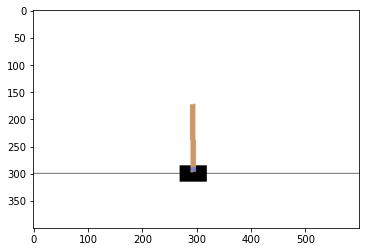

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states. Let's define such a model below.

In [3]:
import torch
import torch.nn as nn

In [180]:
class my_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4, 51)
        self.dropout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(51, 73)
        self.dropout2 = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(73, 2)
        
    def forward(self, x):
        h = self.linear1(x)
        #h = self.dropout1(h)
        h = self.relu1(h)
        h = self.linear2(h)
        #h = self.dropout2(h)
        h = self.relu2(h)
        h = self.linear3(h)
        return h

model = my_net()

#### Predict function

In [181]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    x = torch.tensor(states, dtype=torch.float32)
    h = model(x)
    prob = torch.softmax(h, -1).data.numpy()
    
    return prob

### Play the game

In [183]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions andrewards
    """
    # arrays to record session
    states, actions, rewards, probs = [], [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]
        probs.append(action_probs)

        # Sample action with given probabilities.
        a = action_probs.argmax()
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [184]:
# test it
states, actions, rewards = generate_session()

### Computing cumulative rewards

In [185]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    rewards.reverse()
    G = [rewards[0]]
    for r in rewards[1:]:
        G.append(gamma*G[-1]+r)
    rewards.reverse()
    G.reverse()
    return G

#### Loss function and updates

In [187]:
def to_one_hot(y_tensor, ndims):
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [188]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

def train_on_session(states, actions, rewards, gamma=0.9, entropy_coef=1e-0):
    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    #cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    #cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)
    cumulative_returns = torch.tensor(rewards, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forgen entropy regularization with `entropy_coef` 
    entropy = probs * log_probs
    loss = (log_probs_for_actions*cumulative_returns).mean()# + (1/entropy_coef)*entropy.mean()

    # Gradient descent step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [191]:
avr_rewards4 = []

for i in range(100):
    rewards = [train_on_session(*generate_session(), gamma=0.99) for _ in range(100)]  # generate new sessions
    avr_rewards4.append(np.mean(rewards))
    
    print("mean reward:%.3f" % (np.mean(rewards)))
    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break

mean reward:56.790
mean reward:76.400
mean reward:106.190
mean reward:73.000
mean reward:108.250
mean reward:67.330
mean reward:112.000
mean reward:104.910
mean reward:91.330
mean reward:102.420
mean reward:76.430
mean reward:52.390
mean reward:71.070
mean reward:101.050
mean reward:170.120
mean reward:99.490
mean reward:261.920
mean reward:156.990
mean reward:86.740
mean reward:142.290
mean reward:142.050
mean reward:127.960
mean reward:124.470
mean reward:194.470
mean reward:176.150
mean reward:174.140
mean reward:191.890
mean reward:124.280
mean reward:166.480
mean reward:151.650
mean reward:88.050
mean reward:159.420
mean reward:193.510
mean reward:106.760
mean reward:213.440
mean reward:134.120
mean reward:107.490
mean reward:149.280
mean reward:127.090
mean reward:60.110
mean reward:78.970
mean reward:157.600
mean reward:196.970
mean reward:198.320
mean reward:140.430
mean reward:80.930
mean reward:142.700
mean reward:101.540
mean reward:136.820
mean reward:74.180
mean reward:81.

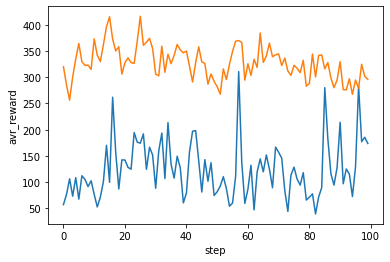

In [194]:
plt.plot(avr_rewards4)
plt.plot(avr_rewards5)

plt.xlabel('step')
plt.ylabel('avr_reward');